In [ ]:
!pip install emoji
!pip install nltk
!pip install scikit-learn
!pip install xgboost
!pip install transformers
!pip install torch
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re
import emoji
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Women Abuse/AWT_train.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Women Abuse/AWT_dev.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Women Abuse/AWT_test_without_labels.csv')

In [ ]:
train_data.head()

,Text,Class
0,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று,Non-Abusive
1,"யாருடா அந்த கார்த்தி, நீ எங்கடா இருக்க ?",Non-Abusive
2,இரண்டு பேரின் (புண்டையை) சாமான்களை கோணிய ஊசால்...,Abusive
3,என்ன திமிர் இந்த பொண்ணுக்கு.....மக்களே இன்னும்...,Abusive
4,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா please,Non-Abusive


In [ ]:
train_data.shape

(2790, 2)

In [ ]:
unique_labels = train_data['Class'].unique()
print(unique_labels)

['Non-Abusive' 'Abusive' 'abusive']


In [ ]:
label_counts = train_data['Class'].value_counts()
print(label_counts)

Class
Non-Abusive    1424
Abusive        1365
abusive           1
Name: count, dtype: int64


In [ ]:
train_data = train_data[train_data['Class'] != 'abusive']

In [ ]:
label_counts = train_data['Class'].value_counts()
print(label_counts)

Class
Non-Abusive    1424
Abusive        1365
Name: count, dtype: int64


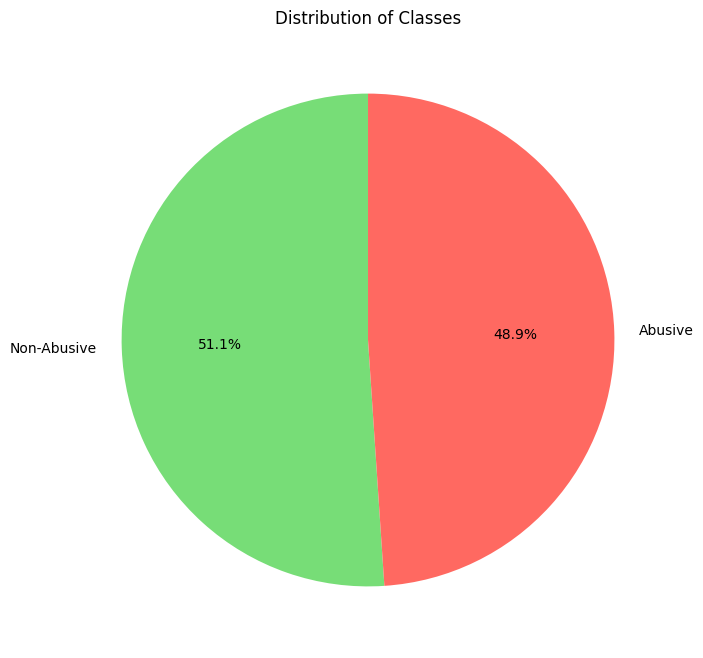

In [ ]:
colors = ['#77DD77', '#FF6961']

fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)

ax.set_title('Distribution of Classes')
plt.show()

In [ ]:
stop_word_file_path = '/content/drive/MyDrive/Sentiment Analysis/TamilStopWords.txt'

with open(stop_word_file_path, 'r') as file:
      stop_words_list = [line.strip() for line in file]

print(stop_words_list)

stop_words_list.append(stopwords.words('english'))

print(stop_words_list)

['அங்கு', 'அங்கே', 'அடுத்த', 'அதற்கு', 'அதனால்', 'அதன்', 'அதிக', 'அதில்', 'அது', 'அதே', 'அதை', 'அந்த', 'அந்தக்', 'அந்தப்', 'அல்லது', 'அவரது', 'அவர்', 'அவர்கள்', 'அவள்', 'அவன்', 'அவை', 'அன்று', 'ஆகிய', 'ஆகியோர்', 'ஆகும்', 'ஆனால்', 'இங்கு', 'இங்கே', 'இடத்தில்', 'இடம்', 'இதற்கு', 'இதனால்', 'இதனை', 'இதன்', 'இதில்', 'இது', 'இதை', 'இந்த', 'இந்தக்', 'இந்தத்', 'இந்தப்', 'இப்போது', 'இரு', 'இருக்கும்', 'இருந்த', 'இருந்தது', 'இருந்து', 'இல்லை', 'இவர்', 'இவை', 'இன்னும்', 'உள்ள', 'உள்ளது', 'உள்ளன', 'உன்', 'எந்த', 'எல்லாம்', 'என', 'எனக்', 'எனக்கு', 'எனப்படும்', 'எனவும்', 'எனவே', 'எனினும்', 'எனும்', 'என்', 'என்பது', 'என்பதை', 'என்ற', 'என்று', 'என்றும்', 'என்ன', 'என்னும்', 'ஏன்', 'ஒரு', 'ஒரே', 'ஓர்', 'கொண்ட', 'கொண்டு', 'கொள்ள', 'சற்று', 'சில', 'சிறு', 'சேர்ந்த', 'தவிர', 'தனது', 'தன்', 'தான்', 'நாம்', 'நான்', 'நீ', 'பல', 'பலரும்', 'பல்வேறு', 'பற்றி', 'பற்றிய', 'பிற', 'பிறகு', 'பின்', 'பின்னர்', 'பெரும்', 'பேர்', 'போது', 'போல', 'போல்', 'போன்ற', 'மட்டுமே', 'மட்டும்', 'மற்ற', 'மற்றும்', 'மிக', 'மிகவும்', 

In [ ]:
def clean_tamil_comments(comments):
    clean_comments = []

    for text in comments:

        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r"\S+@\S+\.\S+", "", text)

        # Remove emojis
        text = emoji.demojize(text, delimiters=(":", ":"))
        text = re.sub(r':\S+?:', '', text)

        # Convert English letters to lowercase while preserving Tamil script
        text = re.sub(
            r"[A-Za-z]+",
            lambda match: match.group(0).lower(),
            text
        )

        # Remove special characters and punctuation (retain Tamil script as text)
        text = re.sub(r"[^\w\s\u0B80-\u0BFF:]+", "", text)

        # Remove numbers
        text = re.sub(r"\d+", "", text)

        # Normalize spaces
        text = re.sub(r"\s+", " ", text).strip()

        clean_comments.append(text)

    return clean_comments

In [ ]:
def tokenize(comments):
    return [word_tokenize(comment) for comment in comments]

In [ ]:
def remove_stop_words(comments):
  for words in comments:
    filtered_words = [word for word in words if word not in stop_words_list]
    words[:] = filtered_words
  return comments

In [ ]:
def preprocess(comments):
  index = random.randint(0, len(comments) - 1)
  print("Original:", comments[index])

  comments = clean_tamil_comments(comments)
  print("Cleaned:", comments[index])

  comments = tokenize(comments)
  print("Tokenised:", comments[index])

  comments = remove_stop_words(comments)
  print("After Stop Words Removal:", comments[index])

  return comments

In [ ]:
train_data['clean_content'] = preprocess(train_data['Text'])

Original: சகிலா அம்மா உங்கள் நேர்காணல் மிகவும் கண்ணியமாக உள்ளது.
Cleaned: குஷ்புவே ஒரு தாமரை தான் அவளோ பெருசு எங்க குஷ்பூவோட தாமரை
Tokenised: ['குஷ்புவே', 'ஒரு', 'தாமரை', 'தான்', 'அவளோ', 'பெருசு', 'எங்க', 'குஷ்பூவோட', 'தாமரை']
After Stop Words Removal: ['குஷ்புவே', 'தாமரை', 'அவளோ', 'பெருசு', 'எங்க', 'குஷ்பூவோட', 'தாமரை']


In [ ]:
validation_data['clean_content'] = preprocess(validation_data['Text'])

Original: குழந்தை யில் ஜட்டி யுடன் ஆடின  இப்ப ஜட்டி இல்லாமல் அடிகிட்டு இருக்கா
Cleaned: குழந்தை யில் ஜட்டி யுடன் ஆடின இப்ப ஜட்டி இல்லாமல் அடிகிட்டு இருக்கா
Tokenised: ['குழந்தை', 'யில்', 'ஜட்டி', 'யுடன்', 'ஆடின', 'இப்ப', 'ஜட்டி', 'இல்லாமல்', 'அடிகிட்டு', 'இருக்கா']
After Stop Words Removal: ['குழந்தை', 'யில்', 'ஜட்டி', 'யுடன்', 'ஆடின', 'இப்ப', 'ஜட்டி', 'இல்லாமல்', 'அடிகிட்டு', 'இருக்கா']


In [ ]:
train_data.head()

,Text,Class,clean_content
0,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று,Non-Abusive,"[இதல்லம், தீர்ப்பு, நாட்டாமை, தீர்ப்பை, மற்று]"
1,"யாருடா அந்த கார்த்தி, நீ எங்கடா இருக்க ?",Non-Abusive,"[யாருடா, கார்த்தி, எங்கடா, இருக்க]"
2,இரண்டு பேரின் (புண்டையை) சாமான்களை கோணிய ஊசால்...,Abusive,"[இரண்டு, பேரின், புண்டையை, சாமான்களை, கோணிய, ஊ..."
3,என்ன திமிர் இந்த பொண்ணுக்கு.....மக்களே இன்னும்...,Abusive,"[திமிர், பொண்ணுக்குமக்களே, இவளுடைய, வீடியோக்கள..."
4,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா please,Non-Abusive,"[ஐயோ, கார்த்திக், எ, காட்டுங்க, பா, please]"


In [ ]:
label_mapping = {label: idx for idx, label in enumerate(train_data['Class'].unique())}
train_data['numerical_labels'] = train_data['Class'].map(label_mapping)
validation_data['numerical_labels'] = validation_data['Class'].map(label_mapping)

In [ ]:
train_data.head()

,Text,Class,clean_content,numerical_labels
0,இதல்லம் ஒரு தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று,Non-Abusive,"[இதல்லம், தீர்ப்பு, நாட்டாமை, தீர்ப்பை, மற்று]",0
1,"யாருடா அந்த கார்த்தி, நீ எங்கடா இருக்க ?",Non-Abusive,"[யாருடா, கார்த்தி, எங்கடா, இருக்க]",0
2,இரண்டு பேரின் (புண்டையை) சாமான்களை கோணிய ஊசால்...,Abusive,"[இரண்டு, பேரின், புண்டையை, சாமான்களை, கோணிய, ஊ...",1
3,என்ன திமிர் இந்த பொண்ணுக்கு.....மக்களே இன்னும்...,Abusive,"[திமிர், பொண்ணுக்குமக்களே, இவளுடைய, வீடியோக்கள...",1
4,ஐயோ அந்த கார்த்திக் எ காட்டுங்க பா please,Non-Abusive,"[ஐயோ, கார்த்திக், எ, காட்டுங்க, பா, please]",0


In [ ]:
X_train = [' '.join(comment) for comment in train_data['clean_content']]
y_train = train_data['numerical_labels']

In [ ]:
X_val = [' '.join(comment) for comment in validation_data['clean_content']]
y_val = validation_data['numerical_labels']

In [ ]:
print(set(y_train))
print(set(y_val))

{0, 1}
{0, 1}


In [ ]:
# Step 1: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

# Step 2: Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Convert your data into Hugging Face Dataset format
train_data = Dataset.from_dict({"text": X_train, "label": y_train})
val_data = Dataset.from_dict({"text": X_val, "label": y_val})

# Tokenize the datasets
train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)

# Set format for PyTorch
train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Step 3: Define the metrics
def compute_metrics(pred):
    predictions = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(pred.label_ids, predictions)
    f1 = f1_score(pred.label_ids, predictions)
    precision = precision_score(pred.label_ids, predictions)
    recall = recall_score(pred.label_ids, predictions)
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Step 4: Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42,
    report_to="none",
)

# Step 5: Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Step 6: Train the model
trainer.train()

# Step 7: Evaluate the model
results = trainer.evaluate()
print("Final Evaluation Results:", results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2789 [00:00<?, ? examples/s]

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-6227129f1458>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.643300,0.638194,0.697324,0.726172,0.626632,0.863309
2,0.569300,0.562680,0.747492,0.752864,0.690691,0.827338
3,0.516000,0.546143,0.755853,0.759076,0.701220,0.827338
4,0.371100,0.518981,0.775920,0.761566,0.753521,0.769784
5,0.413700,0.520954,0.777592,0.776471,0.728707,0.830935


Final Evaluation Results: {'eval_loss': 0.5209535956382751, 'eval_accuracy': 0.7775919732441472, 'eval_f1': 0.7764705882352941, 'eval_precision': 0.7287066246056783, 'eval_recall': 0.8309352517985612, 'eval_runtime': 4.1355, 'eval_samples_per_second': 144.6, 'eval_steps_per_second': 9.189, 'epoch': 5.0}


In [ ]:
# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/Women Abuse/saved_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Women Abuse/saved_model")

('/content/drive/MyDrive/Women Abuse/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/Women Abuse/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/Women Abuse/saved_model/vocab.txt',
 '/content/drive/MyDrive/Women Abuse/saved_model/added_tokens.json',
 '/content/drive/MyDrive/Women Abuse/saved_model/tokenizer.json')

In [ ]:
# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Women Abuse/saved_model")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Women Abuse/saved_model")

# Prepare new data
new_texts = ["இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒர்க் அவளுக்கு இருக்குறது தண்ணிய போட்டுட்டு அசிங்கமா பேசுறது.", "நாட்டுக்கும் வீட்டுக்கும் ரொம்ப முக்கியம் என்ன பொய்யடா சாமி"]
encoded_inputs = tokenizer(new_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

# Move model and data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
encoded_inputs = {key: val.to(device) for key, val in encoded_inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, axis=1)

print("Predicted Labels:", predictions.cpu().numpy())

Predicted Labels: [1 0]


In [ ]:
test_data.head()

,id,Text
0,1,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...
1,2,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...
2,3,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...
3,4,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...
4,5,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...


In [ ]:
test_data['clean_content'] = preprocess(test_data['Text'])
X_test = [' '.join(comment) for comment in test_data['clean_content']]

Original: அழகி போட்டி இல்லை. கிழவி போட்டியில் நீ வென்றாய்..
Cleaned: அழகி போட்டி இல்லை கிழவி போட்டியில் நீ வென்றாய்
Tokenised: ['அழகி', 'போட்டி', 'இல்லை', 'கிழவி', 'போட்டியில்', 'நீ', 'வென்றாய்']
After Stop Words Removal: ['அழகி', 'போட்டி', 'கிழவி', 'போட்டியில்', 'வென்றாய்']


In [ ]:
encoded_inputs = tokenizer(X_test, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
encoded_inputs = {key: val.to(device) for key, val in encoded_inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, axis=1)

print("Predicted Labels:\n", predictions.cpu().numpy())

Predicted Labels:
 [1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0
 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1
 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1
 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1
 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1
 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1
 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1
 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1
 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0
 1 0 1

In [ ]:
mapping = {0: 'Non-Abusive', 1: 'Abusive'}
test_data['Predicted Class'] = predictions.cpu().numpy()
test_data['Predicted Class'] = test_data['Predicted Class'].map(mapping)

In [ ]:
test_data.head()

,id,Text,clean_content,Predicted Class
0,1,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...,"[இவ, மானெங்கெட்ட, பொறுக்கி, routine, ஒர்க், அவ...",Abusive
1,2,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...,"[இப்டியே, பேசிக்கிட்டே, இருந்தா, எப்டி, யாரு, ...",Abusive
2,3,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,"[அடக், கடவுளே, என்னக், கொடுமையை, ஊருல, உலகத்து...",Non-Abusive
3,4,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...,"[தீர்வு, இருக்கு, வேலை, பார்த்தால், பாதிப்பும்...",Non-Abusive
4,5,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,"[தம்பி, போய், நல்லவங்களை, பேட்டிஎடு, அவ, சொல்வ...",Abusive


In [ ]:
print_data = test_data[['Text', 'Predicted Class']]

In [ ]:
print_data.head()

,Text,Predicted Class
0,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...,Abusive
1,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...,Abusive
2,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,Non-Abusive
3,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...,Non-Abusive
4,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,Abusive


In [ ]:
print_data = print_data.rename(columns={'Text': 'Id', 'Predicted Class': 'Labels'})
print_data.head()

,Id,Labels
0,இவ ஒரு மானெங்கெட்ட பொறுக்கி. ஒரே ஒரு routine ஒ...,Abusive
1,இப்டியே பேசிக்கிட்டே இருந்தா எப்டி..... யாரு ப...,Abusive
2,அடக் கடவுளே இது என்னக் கொடுமையை ஊருல உலகத்துல ...,Non-Abusive
3,இதற்கு ஒரு தீர்வு இருக்கு. அவன் அவன் வேலை அவன...,Non-Abusive
4,தம்பி போய் நல்லவங்களை பேட்டிஎடு அவ சொல்வது அத்...,Abusive


In [ ]:
print_data.to_csv('/content/drive/MyDrive/JAS_Tamil.csv', index=False)

# Tried and Tested

In [ ]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [ ]:
print(X_train[0])
print(X_train_tfidf[0])

இதல்லம் தீர்ப்பு நாட்டாமை தீர்ப்பை மற்று
  (0, 1121)	0.6758766554984857
  (0, 2082)	0.5079275051970673
  (0, 1915)	0.5340415676859475


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000,solver='saga')

log_reg_model.fit(X_train_tfidf, y_train)

y_pred = log_reg_model.predict(X_val_tfidf)

print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.71       320
           1       0.66      0.65      0.66       278

    accuracy                           0.68       598
   macro avg       0.68      0.68      0.68       598
weighted avg       0.68      0.68      0.68       598



In [ ]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(X_train_tfidf, y_train)

y_pred = svc_model.predict(X_val_tfidf)

print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72       320
           1       0.68      0.68      0.68       278

    accuracy                           0.70       598
   macro avg       0.70      0.70      0.70       598
weighted avg       0.70      0.70      0.70       598



In [ ]:
from sklearn.svm import LinearSVC

lsvc_model = LinearSVC(random_state=0)

lsvc_model.fit(X_train_tfidf, y_train)

y_pred = lsvc_model.predict(X_val_tfidf)

print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70       320
           1       0.66      0.67      0.66       278

    accuracy                           0.68       598
   macro avg       0.68      0.68      0.68       598
weighted avg       0.68      0.68      0.68       598



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_tfidf, y_train)

y_pred = xgb_model.predict(X_val_tfidf)

print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69       320
           1       0.64      0.59      0.61       278

    accuracy                           0.66       598
   macro avg       0.65      0.65      0.65       598
weighted avg       0.65      0.66      0.65       598

